In [1219]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bike-sharing-demand/test.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv


### Options

In [1220]:
plot = False
hour_shift = False
dummies=True
dummy_day = False
dummy_month = True #ok
dummy_year = True # ok
dummy_hour = True # ok
log_count = True #ok
drop_season = False #Ok
count_99pct = False
count_season = True

# Load and describe the train set

In [1221]:
df = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
df.head(25)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [1222]:
df.isnull().sum()  #  no null values --> no imputation needed 

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [1223]:
df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

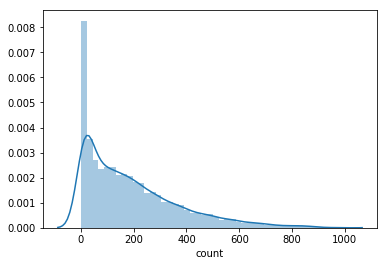

In [1224]:
sns.distplot(df['count']) #right skewed --> need a log transformation ?

In [1225]:
df.describe()
#datetime - hourly date + timestamp  
#season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
#holiday - whether the day is considered a holiday
#workingday - whether the day is neither a weekend nor holiday
#weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    #2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    #3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    #4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
#temp - temperature in Celsius
#atemp - "feels like" temperature in Celsius
#humidity - relative humidity
#windspeed - wind speed
#casual - number of non-registered user rentals initiated
#registered - number of registered user rentals initiated
#count - number of total rentals

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# Data analysis and minor modifications
## Create readable Hour-day-month-year features

In [1226]:
def get_dayofweekMonthYear(df):
    df['year']= pd.DatetimeIndex(df['datetime']).year.map({2011:0,2012:1})
    df['month']= pd.DatetimeIndex(df['datetime']).month
    df['day']= pd.DatetimeIndex(df['datetime']).dayofweek
    df['H']= pd.DatetimeIndex(df['datetime']).hour
    return df
df = get_dayofweekMonthYear(df)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,H
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,0,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,0,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,0,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0,1,5,4


In [1227]:
df['day_month_year'] = pd.to_datetime(df['datetime']).dt.to_period('D')

if plot :
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    df[df.year==0].groupby(['day_month_year'])['count'].sum().plot(ax=ax1)
    df[df.year==1].groupby(['day_month_year'])['count'].sum().plot(ax=ax1)
    ax1.set_title('sum of counts per day')
    df[df.year==0].groupby(['day_month_year'])['count'].max().plot(ax=ax2)
    df[df.year==1].groupby(['day_month_year'])['count'].max().plot(ax=ax2)
    ax2.set_title('max of counts per day')


In [1228]:
if plot :
    sns.distplot(df[df['count']>df['count'].mean()*2].H)
    #sns.distplot(df[df['count']>800].H)

## Create a new cat variable for the type of day to differentiate holyday and week-end

In [1229]:
# Creation of a new categorical variable 
# 1 = Working, 2 = holiday, 0=week-end
def create_typeday(df):
    cond = [
    (df['workingday'] == 0) & (df['holiday'] == 0),
    (df['workingday'] == 1) & (df['holiday'] == 0),
    (df['workingday'] == 0) & (df['holiday'] == 1)]
    choices = [0,1,2]
    df['typeday'] = np.select(cond,choices)
    return df
df = create_typeday(df)
if plot : 
    f, ax = plt.subplots(1, 1)
    sns.lineplot('H','count',hue='typeday',data = df,palette=["green",'red','blue'],estimator="mean",ax=ax)
    ax.legend(handles=ax.lines[:3], labels=["Week-end","Working","Holiday"])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,H,day_month_year,typeday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,5,0,2011-01-01,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,0,1,5,1,2011-01-01,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,0,1,5,2,2011-01-01,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,0,1,5,3,2011-01-01,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0,1,5,4,2011-01-01,0


In [1230]:
if plot :
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    sns.lineplot('H','count',hue='weather',data = df[df['typeday']!=1],ax=ax1)
    sns.lineplot('H','count',hue='weather',data = df[df['typeday']==1],ax=ax2)

## Temperatures
- temp and atemp are colinear, we will focus on 'atemp' feature
- distribution is not skewed
- we will try to cut it in bins

In [1231]:
df['atemp'].describe()


count    10886.000000
mean        23.655084
std          8.474601
min          0.760000
25%         16.665000
50%         24.240000
75%         31.060000
max         45.455000
Name: atemp, dtype: float64

In [1232]:
if plot :
    sns.distplot(df['atemp'])


In [1233]:
#df['atemp'].plot()
def create_bins(df,feature,nb_bins):
    group_names = range(nb_bins)
    new_df=df.copy()
    new_df[feature+'_cat'] = pd.qcut(df[feature], q=nb_bins)
    print(new_df[feature+'_cat'].unique())
    new_df[feature+'_cat'] = pd.qcut(df[feature], q=nb_bins,labels=group_names).astype(int)
    return new_df


df = create_bins(df,'atemp',6)
df

[(0.759, 14.395], (14.395, 19.695], (19.695, 24.24], (24.24, 28.79], (28.79, 32.575], (32.575, 45.455]]
Categories (6, interval[float64]): [(0.759, 14.395] < (14.395, 19.695] < (19.695, 24.24] < (24.24, 28.79] < (28.79, 32.575] < (32.575, 45.455]]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,H,day_month_year,typeday,atemp_cat
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1,5,0,2011-01-01,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,0,1,5,1,2011-01-01,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,0,1,5,2,2011-01-01,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,0,1,5,3,2011-01-01,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,0,1,5,4,2011-01-01,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,1,12,2,19,2012-12-19,1,1
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,1,12,2,20,2012-12-19,1,1
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,1,12,2,21,2012-12-19,1,1
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,1,12,2,22,2012-12-19,1,1


## ------ Data viz -------

In [1234]:
if plot :
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    sns.lineplot('H','count',hue='atemp_cat',data = df[df['typeday']==1],ax=ax1)
    sns.lineplot('H','count',hue='atemp_cat',data = df[df['typeday']!=1],ax=ax2)
    sns.factorplot(x="atemp_cat",y="count",data=df,kind='bar')

In [1235]:
if plot :
    fig, (ax1) = plt.subplots(1,1,figsize=(13,5))
    sns.lineplot('H','count',hue='day',data = df,ax=ax1)

In [1236]:
df.windspeed.describe()
#drop the windspeed variable ?
#sns.distplot(df.windspeed)
if plot :
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    sns.lineplot('windspeed','count',hue='weather',data = df[df['typeday']==1],ax=ax1)
    sns.lineplot('windspeed','count',hue='weather',data = df[df['typeday']==0],ax=ax2)

In [1237]:
df['humidity'].describe()
df = create_bins(df,'humidity',4)

[(77.0, 100.0], (62.0, 77.0], (47.0, 62.0], (-0.001, 47.0]]
Categories (4, interval[float64]): [(-0.001, 47.0] < (47.0, 62.0] < (62.0, 77.0] < (77.0, 100.0]]


In [1238]:
if plot :
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    sns.lineplot('H','count',hue='humidity_cat',data = df[df['typeday']==1],ax=ax1)
    sns.lineplot('H','count',hue='humidity_cat',data = df[df['typeday']!=1],ax=ax2)
    sns.factorplot(x="humidity_cat",y="count",data=df,kind='bar')

In [1239]:
if plot :
    fig, (ax1) = plt.subplots(1,1,figsize=(14,5))
    sns.lineplot('H','count',hue='season',data = df,ax=ax1)
    ax1.legend(handles=ax1.lines[:4], labels=["Spring","Summer","Fall","Winter"])

# ------- Data analysis and beginning of feature engineering -------

In [1240]:

def shift_feature(df,feature,shifts):
    new_features = []
    for i in shifts:
        df[feature+str(i + 1)] = df['count'].shift(i + 1)
        df[feature+str(i + 1)].fillna(0, inplace=True)
        df[feature+str(i + 1)]=df[feature+str(i + 1)].astype(int)
        new_features.append(feature+str(i + 1))
    return new_features,df
if hour_shift:
    feature = 'count_shifted_H_'
    shift_hours = [0,1]
    new_features,df = shift_feature(df,feature,shift_hours)
    df[['datetime','temp','count']+new_features].head()

In [1241]:
if plot:
    cor_mat= df[:].corr()
    fig=plt.gcf()
    fig.set_size_inches(30,12)
    sns.heatmap(data=cor_mat,square=True,annot=True,cbar=True)

### Ideas 
- holiday =1 -> workingday =0
  y a t-il une difference entre holiday et wkday=0 (weekend + holiday) --> oui mais regrouper en 1 feature commune ? OK
  - plot dist(count) en fonction e l'heure pour les wkday et les non-wkday --> ok
- 2011 et 2012 très différentes, il faut apprendre sur le début de chaque mois et pas sur les 2 années
- créer une lag feature sur le jour, si le jour suivant est holiday ou weekend
- grouper par season, working, count
- plot atemp,count : creer des categorie de temperature
- plot casual, register en fonction de l'heure

-Engineering :
  dummies pour season, weather...


In [1242]:
# Get dummies
if count_season:
    df['year_season'] = df['year'] + df['season'] / 10
    by_season = df.groupby('year_season')[['count']].median()
    by_season.columns = ['count_season']
    df = df.join(by_season, on='year_season')
    df.drop(['year_season'],axis=1, inplace=True)

def dummies(df,dummies,dummy_day,dummy_month,dummy_hour,dummy_year):
    if dummies :
        seas = pd.get_dummies(df['season'],prefix='season')
        weath = pd.get_dummies(df['weather'],prefix='weather')
        typeday = pd.get_dummies(df['typeday'],prefix='typeday')
        atemp_cat = pd.get_dummies(df['atemp_cat'],prefix='atemp_cat')
        humid_cat = pd.get_dummies(df['humidity_cat'],prefix='humidity_cat')
        df=pd.concat([df,seas],axis=1)
        df=pd.concat([df,weath],axis=1)
        df=pd.concat([df,typeday],axis=1)
        df=pd.concat([df,atemp_cat],axis=1)
        df=pd.concat([df,humid_cat],axis=1)
        df.drop(['season','weather','typeday','atemp_cat','humidity_cat'],axis=1,inplace=True)
    
    if dummy_day:
        day_ = pd.get_dummies(df['day'],prefix='day')
        df=pd.concat([df,day_],axis=1)
        df.drop(['day'],axis=1,inplace=True)
    if dummy_month:
        month_ = pd.get_dummies(df['month'],prefix='month')
        df=pd.concat([df,month_],axis=1)
        df.drop(['month'],axis=1,inplace=True)
    if dummy_hour:
        hour_ = pd.get_dummies(df['H'],prefix='h')
        df=pd.concat([df,hour_],axis=1)
        df.drop(['H'],axis=1,inplace=True)
    if dummy_year:
        year_ = pd.get_dummies(df['year'],prefix='year')
        df=pd.concat([df,year_],axis=1)
        df.drop(['year'],axis=1,inplace=True)
    return df
df = dummies(df,dummies,dummy_day,dummy_month,dummy_hour,dummy_year)
# Drop unused columns
df.drop(['atemp','temp','humidity','windspeed','casual','registered','day_month_year','workingday','holiday'],axis=1, inplace=True)
if drop_season :
    col = [i for i in df.columns if i.startswith("seas")]
    df.drop(col,axis=1, inplace=True)



print(len(df.columns))
df.columns

63


Index(['datetime', 'count', 'day', 'count_season', 'season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'typeday_0', 'typeday_1', 'typeday_2', 'atemp_cat_0',
       'atemp_cat_1', 'atemp_cat_2', 'atemp_cat_3', 'atemp_cat_4',
       'atemp_cat_5', 'humidity_cat_0', 'humidity_cat_1', 'humidity_cat_2',
       'humidity_cat_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7',
       'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16',
       'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22', 'h_23', 'year_0',
       'year_1'],
      dtype='object')

## optional Data transformation

In [1243]:
if log_count:
    df['count']=df['count'].apply(lambda x:np.log(x))

In [1244]:
if count_99pct:
    cnt=df['count'].values
    q99=np.percentile(cnt,[99])
    df=df[df['count']<q99[0]]

# Test set preparation

In [1245]:
# Test set prep
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')
test = get_dayofweekMonthYear(test)
#test['year']= pd.DatetimeIndex(test['datetime']).year.map({2011:0,2012:1})
#test['month']= pd.DatetimeIndex(test['datetime']).month
#test['day']= pd.DatetimeIndex(test['datetime']).dayofweek
#test['H']= pd.DatetimeIndex(test['datetime']).hour

test = create_bins(test,'humidity',4)
test = create_bins(test,'atemp',6)
test = create_typeday(test)

if count_season:
    test['year_season'] = test['year'] + test['season'] / 10
    test = test.join(by_season, on='year_season')
    test.drop(['year_season'],axis=1, inplace=True)
    
test = dummies(test,dummies,dummy_day,dummy_month,dummy_hour,dummy_year)

date = test['datetime']
test.drop(['atemp','temp','humidity','windspeed','workingday','holiday'],axis=1, inplace=True)

if drop_season :
    col = [i for i in test.columns if i.startswith("seas")]
    test.drop(col,axis=1, inplace=True)

print(len(test.columns))
test.columns
test.drop(['datetime'],axis=1, inplace=True)

[(49.0, 65.0], (15.999, 49.0], (65.0, 81.0], (81.0, 100.0]]
Categories (4, interval[float64]): [(15.999, 49.0] < (49.0, 65.0] < (65.0, 81.0] < (81.0, 100.0]]
[(-0.001, 14.395], (14.395, 19.695], (19.695, 25.0], (25.0, 29.545], (29.545, 33.335], (33.335, 50.0]]
Categories (6, interval[float64]): [(-0.001, 14.395] < (14.395, 19.695] < (19.695, 25.0] < (25.0, 29.545] < (29.545, 33.335] < (33.335, 50.0]]
62


In [1246]:
if drop_season :
    col = [i for i in test.columns if i.startswith("seas")]
    test.drop(col,axis=1, inplace=True)
    df.drop(col,axis=1, inplace=True)


In [1247]:
test.dtypes

day             int64
count_season    int64
season_1        uint8
season_2        uint8
season_3        uint8
                ...  
h_21            uint8
h_22            uint8
h_23            uint8
year_0          uint8
year_1          uint8
Length: 61, dtype: object

## More ideas
- log transformation for count train_df['count']=train_df['count'].apply(lambda x:np.log(x))
- supprimer cnt=train_df['count'].values ; q99=np.percentile(cnt,[99]) ; train_df=train_df[train_df['count']<q99[0]]
- supprimer saison car coliearie avec month
- essayer dummy sur dayOfWeek
- supprimer day, pas utile
- remplacer atemp par temp
- windspeed has a lot of outliers... à spprimer
- pas dummy sur temp, humidity mais minmaxscaler

# ------------ MODEL---------

In [1248]:
from sklearn.model_selection import train_test_split
X = df.drop(['datetime','count'],axis = 1)
y = df['count']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X.head()

,day,count_season,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,...,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,year_0,year_1
0,5,57,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,5,57,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,5,57,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,5,57,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,57,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### create the metric : root mean squared log error

In [1249]:

def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### Grid search

In [1250]:
parameters = {
    "learning_rate": [0.01],
    #"min_samples_split": [1,10,100],
    #"min_samples_leaf": [0.1,10,100],
    "max_depth":[8],
    "subsample":[0.6],
    "n_estimators":[1500]
    }

mod = GridSearchCV(GradientBoostingRegressor(), parameters, cv=2, n_jobs=-1,verbose = 2)
mod.fit(X_train, y_train)
print(mod.best_params_)
print(mod.cv_results_)
print(mod.best_score_)
y_test_pred = mod.predict(X_test)
print('\n','rmsle:',rmsle(y_test,y_test_pred))



Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.4s finished


{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1500, 'subsample': 0.6}
{'mean_fit_time': array([14.70779669]), 'std_fit_time': array([0.06182921]), 'mean_score_time': array([0.2657851]), 'std_score_time': array([0.00099766]), 'param_learning_rate': masked_array(data=[0.01],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[8],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[1500],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.6],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1500, 'subsample': 0.6}], 'split0_test_score': array([0.94306786]), 'split1_test_score': array([0.94291431]), 'mean_test_score': array([0.94299109]), 'std_test_score': array([7.6773761e-05]), 'rank_test_scor

### Just trying an other XGBreg implementation

In [1251]:
import xgboost as xg
xgr=xg.XGBRegressor(max_depth=8,gamma=0.4,colsample_bytree=0.6,subsample=0.6)
xgr.fit(X_train, y_train)
y_test_pred = xgr.predict(X_test)
print('rmsle:',rmsle(y_test,y_test_pred))

rmsle: 0.12165358614894228


In [1252]:
pred = mod.predict(test)

if not log_count:
    submission = pd.DataFrame({
        "datetime": date,
        "count": [max(0, x) for x in pred]
    })
else :
    submission = pd.DataFrame({
        "datetime": date,
        "count": [np.exp(x) for x in pred]
    })

submission.head()

,datetime,count
0,2011-01-20 00:00:00,9.337180
1,2011-01-20 01:00:00,2.786529
2,2011-01-20 02:00:00,2.059256
3,2011-01-20 03:00:00,2.993611
4,2011-01-20 04:00:00,2.391262


In [1253]:
submission.to_csv('predictions.csv', index=False)
